In [2]:
import numpy as np
import wandb

''' MLP class  '''
class MLP:
    ''' Multi-layer perceptron class '''
    ''' input_size, hidden_layers = [sizes of the hidden layers], output_size, epochs, learning_rate, batch_size, activation_function, loss_function '''
    def __init__(self, input_size, hidden_layers, output_size, epochs = 100, learning_rate = 0.01, early_stopping = False,
                 batch_size = 32, activation_function = 'relu', loss_function = 'mse', optimizer = 'sgd', beta = 0.0, 
                 Random_state = None, weight_init = 'he', model_type = 'class_ML', wandb_vaar = False, run_start = "hyperparam_tuning", wandb_finish = True):
        
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.early_stopping = early_stopping
        self.beta = beta
        self.weight_init = weight_init
        self.model_type = model_type
        self.wandb_vaar = wandb_vaar
        self.wandb_finish = wandb_finish
        
        self.weights = []
        self.biases = []
        self.loss = []
        self.history = []

        self.train_loss = []
        self.val_loss = []
        
        np.random.seed(Random_state)
        
        self._initialize_weights()
        
        run_name = f"{run_start}-{self.activation_function}-{self.optimizer}-{self.loss_function}-{self.weight_init}-{self.epochs}-{self.learning_rate}-{self.batch_size}"
        
        # Initialize WandB
        if wandb_vaar:
            wandb.init(
                project="SMAI_A3-MLP", 
                name=run_name,
                config={
                "learning_rate": self.learning_rate,
                "epochs": self.epochs,
                "batch_size": self.batch_size,
                "activation": self.activation_function,
                "optimizer": self.optimizer,
                "input_size": self.input_size,
                "hidden_layer_sizes": self.hidden_layers,
                "output_size": self.output_size,
                "loss_function": self.loss_function,
                "weight_init": self.weight_init,
                "Random_state": Random_state,
                "beta": self.beta,
                "early_stopping": self.early_stopping,
            })
        
    def _initialize_weights(self):
        ''' Initialize weights '''
        layers = [self.input_size] + self.hidden_layers + [self.output_size]
        for i in range(len(layers) - 1):
            if self.weight_init == 'random':
                self.weights.append(np.random.randn(layers[i], layers[i+1]))  # Random initialization
            
            elif self.weight_init == 'he':
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * np.sqrt(2. / layers[i]))  # He initialization
            
            elif self.weight_init == 'xavier':
                limit = np.sqrt(6 / (layers[i] + layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (layers[i], layers[i+1])))  # Xavier/Glorot initialization
            
            self.biases.append(np.zeros(layers[i+1]))
        
        self.vW = [np.zeros_like(w) for w in self.weights]  # Initialize velocity for weights
        self.vb = [np.zeros_like(b) for b in self.biases]   # Initialize velocity for biases
    
    # Activation functions       
    def relu(self, x):
        ''' ReLU activation function '''
        return np.where(x > 0, x, x * 0.01)
    def relu_derivative(self, x):
        ''' ReLU derivative '''
        return np.where(x > 0, 1, 0.01)
    
    def sigmoid(self, x):
        ''' Sigmoid activation function '''
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, x):
        ''' Sigmoid derivative '''
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tanh(self, x):
        ''' Tanh activation function '''
        return np.tanh(x)
    def tanh_derivative(self, x):
        ''' Tanh derivative '''
        return 1 - np.tanh(x)**2
    
    def linear(self, x):
        ''' Linear activation function '''
        return x
    def linear_derivative(self, x):
        ''' Linear derivative '''
        return 1
            
    def _activation(self, activation_function = None):
        ''' Activation function '''
        if activation_function == 'relu':
            return self.relu, self.relu_derivative
        elif activation_function == 'sigmoid':
            return self.sigmoid, self.sigmoid_derivative
        elif activation_function == 'tanh':
            return self.tanh, self.tanh_derivative
        elif activation_function == 'linear':
            return self.linear, self.linear_derivative
        else:
            raise ValueError('Activation function not supported')
    
    # Optimizers
    def mse(self, y, y_pred):
        ''' Mean squared error '''
        return np.mean((y - y_pred)**2)
    def mse_derivative(self, y, y_pred):
        ''' Mean squared error derivative '''
        return 2*(y_pred - y)
    
    # Loss for regression
    def rmse(self, y, y_pred):
        ''' Root mean squared error '''
        return np.sqrt(np.mean((y - y_pred)**2))
    def mae(self, y, y_pred):
        ''' Mean absolute error '''
        return np.mean(np.abs(y - y_pred))
    def r_squared(self, y, y_pred):
        ''' R-squared metric '''
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        return 1 - (ss_res / ss_tot)
    
    def cross_entropy(self, y, y_pred):
        ''' Cross entropy loss '''
        return -np.sum(y * np.log(y_pred)) / len(y)
    
    def cross_entropy_derivative(self, y, y_pred):
        ''' Cross entropy derivative '''
        return (y_pred - y) # / (y_pred * (1 - y_pred) + 1e-6)  
    
    def _loss(self):
        ''' Loss function '''
        if self.loss_function == 'mse':
            return self.mse, self.mse_derivative
        elif self.loss_function == 'cross_entropy':
            return self.cross_entropy, self.cross_entropy_derivative
        else:
            raise ValueError('Loss function not supported')
        
    def _softmax(self, x):
        ''' Softmax activation function '''
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def _one_hot(self, y):
        ''' One-hot encoding '''
        print(y.min(), y.max())
        one_hot = np.zeros((y.size, y.max()+1- y.min()))
        for i in range(y.size):
            one_hot[i, y[i] - y.min()] = 1
        return one_hot
    
    def filter_onehot(self, y_true, y_test):
        y_true = np.argmax(y_true, axis=1)
        y_test = np.argmax(y_test, axis=1)
        return y_true, y_test
    
    def filter_softmax(self, y_pred):
        # if >0.5, then 1 else 0
        return np.where(y_pred > 0.5, 1, 0)
        
    
    def accuracy(self, y_true, y_pred):
        correct_predictions = np.sum(y_true == y_pred)
        total_predictions = len(y_true)
        return correct_predictions / total_predictions
    
    def hamming_loss(self, y_true, y_pred):
        # Compute the number of incorrectly predicted labels
        incorrect_labels = np.sum(y_true != y_pred)
        
        # Total number of labels is the number of samples times the number of labels per sample
        total_labels = y_true.shape[0] * y_true.shape[1]
        
        # Hamming Loss: Proportion of incorrect labels
        return incorrect_labels / total_labels
    
    def multi_label_partial_accuracy(self, y_true, y_pred):
        y_pred_partial = y_pred.reshape(-1, 1)
        y_true_partial = y_true.reshape(-1, 1)
        partial_accuracy = self.accuracy(y_true_partial, y_pred_partial)
        return partial_accuracy
    
    def multi_label_accuracy(self, y_true, y_pred):
        # Exact match accuracy (where all labels for a sample are correctly predicted)
        correct_predictions = np.sum(np.all(y_true == y_pred, axis=1))
        total_predictions = len(y_true)
        return correct_predictions / total_predictions
    
    def multi_label_confusion_matrix(self, y_true, y_pred):
        num_labels = y_true.shape[1]
        confusion_matrices = []

        for i in range(num_labels):
            tp = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 1))  # True Positive
            tn = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 0))  # True Negative
            fp = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 0))  # False Positive
            fn = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 1))  # False Negative

            matrix = np.array([[tn, fp], [fn, tp]])
            confusion_matrices.append(matrix)

        return np.array(confusion_matrices)
    
    def multi_label_micro_metrics_partial(self, y_true, y_pred):
        # confusion matrix
        confusion_matrix = self.multi_label_confusion_matrix(y_true, y_pred)

        # micro-averaged precision, recall, f1_score
        micro_precision = np.sum(confusion_matrix[:, 0, 0]) / np.sum(confusion_matrix[:, 0, 0] + np.sum(confusion_matrix[:, 1, 0] + 1e-6))
        micro_recall = np.sum(confusion_matrix[:, 0, 0]) / np.sum(confusion_matrix[:, 0, 0] + np.sum(confusion_matrix[:, 1, 1] + 1e-6))
        micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
        
        return micro_precision, micro_recall, micro_f1_score
    
    def multi_label_macro_metrics_partial(self, y_true, y_pred):
        # confusion matrix
        confusion_matrix = self.multi_label_confusion_matrix(y_true, y_pred)

        # macro-averaged precision, recall, f1_score
        macro_precision = np.mean(confusion_matrix[:, 0, 0] / (confusion_matrix[:, 0, 0] + confusion_matrix[:, 1, 0] + 1e-6))
        macro_recall = np.mean(confusion_matrix[:, 0, 0] / (confusion_matrix[:, 0, 0] + confusion_matrix[:, 1, 1] + 1e-6))
        macro_f1_score = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)
        
        return macro_precision, macro_recall, macro_f1_score
    
    def multi_label_precision_recall_f1(self, y_true, y_pred):
        epsilon = 1e-9  # To avoid division by zero

        # True Positives, False Positives, and False Negatives for each label
        true_positives = np.sum((y_pred == 1) & (y_true == 1), axis=0)
        false_positives = np.sum((y_pred == 1) & (y_true == 0), axis=0)
        false_negatives = np.sum((y_pred == 0) & (y_true == 1), axis=0)

        # Precision: TP / (TP + FP)
        precision = true_positives / (true_positives + false_positives + epsilon)
        
        # Recall: TP / (TP + FN)
        recall = true_positives / (true_positives + false_negatives + epsilon)
        
        # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)

        # Return macro-average (mean over all labels)
        return precision, recall, f1
    
    def confusion_matrix(self, y_true, y_pred):
        classes = np.unique(y_true)
        matrix = np.zeros((len(classes), len(classes)), dtype=int)

        for i in range(len(y_true)):
            true_idx = np.where(classes == y_true[i])[0][0]
            pred_idx = np.where(classes == y_pred[i])[0][0]
            matrix[true_idx, pred_idx] += 1
        
        return matrix
    
    def recall(self, y_true, y_pred):
        matrix = self.confusion_matrix(y_true, y_pred)
        recall_values = np.diag(matrix) / np.sum(matrix, axis=1)  # TP / (TP + FN)
        recall_values = np.nan_to_num(recall_values)  # Handle division by zero
        return np.mean(recall_values)
    
    def precision(self, y_true, y_pred):
        matrix = self.confusion_matrix(y_true, y_pred)
        precision_values = np.diag(matrix) / np.sum(matrix, axis=0)  # TP / (TP + FP)
        precision_values = np.nan_to_num(precision_values)  # Handle division by zero
        return np.mean(precision_values)
    
    def f1_score(self, y_true, y_pred):
        prec = self.precision(y_true, y_pred)
        rec = self.recall(y_true, y_pred)
        if (prec + rec) == 0:
            return 0
        return 2 * (prec * rec) / (prec + rec)
    
    def model_functions(self):
        if self.model_type == 'class_ML':
            return self.sigmoid, self.sigmoid_derivative
        elif self.model_type == 'class_MC':
            return self._softmax, self.cross_entropy_derivative
        elif self.model_type == 'regression':
            return self._activation(self.activation_function)
    
    # Forward pass
    def forward(self, X, latent_space = False):
        ''' Forward pass '''
        activations = [X]
        Z = [X]
        
        activation, _ = self._activation(self.activation_function)
        current_activation = X
        
        # Hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(current_activation, self.weights[i]) + self.biases[i]
            Z.append(z)
            current_activation = activation(z)
            activations.append(current_activation)
            
        # Output layer
        z = np.dot(current_activation, self.weights[-1]) + self.biases[-1]
        Z.append(z)
        
        # Check if the model is for classification or regression
        activation_function, _ = self.model_functions()
        # output_activation = self.relu(z) # Output activation function
        output_activation = activation_function(z) # Output activation function
        activations.append(output_activation)
        self.activations = activations
        
        return Z, activations
    
    # Backward pass
    def backward(self, X, y, Z, activations):
        ''' Backward pass '''
        grads = {}
        m = y.shape[0]
        
        # Activation function
        # activation_function, activation_derivative = self._activation(self.activation_function)
        activation_function, activation_derivative = self.model_functions()
        
        # Loss function
        # loss, loss_derivative = self._loss()
        if self.model_type == 'class_ML':
            loss, loss_derivative = self.cross_entropy, self.cross_entropy_derivative
        elif self.model_type == 'class_MC':
            loss, loss_derivative = self.cross_entropy, self.cross_entropy_derivative
        elif self.model_type == 'regression':
            loss, loss_derivative = self.mse, self.mse_derivative
        
        # backprop loss in output layer
        dA = loss_derivative(y, (activations[-1]))
        if self.model_type == 'class_MC':
            dZ = (activations[-1] - y) / m
        else:
            dZ = dA * activation_derivative(Z[-1])
        
        grads["dW" + str(len(self.weights)-1)] = np.dot(activations[-2].T, dZ) / m
        grads["db" + str(len(self.weights)-1)] = np.sum(dZ, axis=0) / m
        self.dZ = dZ
        
        # backprop hidden layers
        activation_function, activation_derivative = self._activation(self.activation_function)
        for i in range(len(self.weights)-2, -1, -1):
            dA = np.dot(dZ, self.weights[i+1].T)
            dZ = dA * activation_derivative(Z[i+1])
            grads["dW" + str(i)] = np.dot(activations[i].T, dZ) / m
            grads["db" + str(i)] = np.sum(dZ, axis=0) / m
        
        self.dZ = dZ
        return grads
    
    # # Update weights
    # def update_weights(self, grads):
    #     ''' Update weights '''
    #     # print('weights:', len(self.weights))
    #     # for i in range(len(self.weights)):
    #     #     print(self.weights[i].shape, grads["dW" + str(i)].shape)
    #     for i in range(len(self.weights)):
    #         self.weights[i] -= self.learning_rate * grads["dW" + str(i)]
    #         self.biases[i] -= self.learning_rate * grads["db" + str(i)]
    
    # update weights using momentum
    def update_weights(self, grads):
        for i in range(len(self.weights)):
            # Update the velocity for weights and biases using momentum
            self.vW[i] = self.beta * self.vW[i] + (1 - self.beta) * grads["dW" + str(i)]
            self.vb[i] = self.beta * self.vb[i] + (1 - self.beta) * grads["db" + str(i)]
            
            # Update the weights and biases using velocity
            self.weights[i] -= self.learning_rate * self.vW[i]
            self.biases[i] -= self.learning_rate * self.vb[i]
            
    # Train the model
    def fit(self, X, y, X_val = None, y_val = None):
        # encode the target variable if it is not regression
        # if not self.model_type == 'regression':
        #     y = self._one_hot(y)
        
        ''' Train the model '''
        for epoch in range(self.epochs):
            self.optimize(X, y)
            print(f"Epoch: {epoch+1}")
            
            # Loss
            loss_func, loss_derivative = self._loss()
            y_pred = self.forward(X)[1][-1] # Predictions
            self.loss.append(loss_func(y, y_pred))

            self.train_loss.append(self.loss[-1])
            
            # Loss on validation set
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                self.history.append(loss_func(y_val, y_pred_val))
                self.val_loss.append(self.history[-1])
            
            # Log accuracy, recall, precision, f1_score
            if self.model_type == 'class_MC' and self.wandb_vaar:
                # train
                y_true, y_pred = self.filter_onehot(y, y_pred)
                accuracy = self.accuracy(y_true, y_pred)
                recall = self.recall(y_true, y_pred)
                precision = self.precision(y_true, y_pred)
                f1_score = self.f1_score(y_true, y_pred)
                # val
                y_true_val, y_pred_val = self.filter_onehot(y_val, y_pred_val)
                accuracy_val = self.accuracy(y_true_val, y_pred_val)
                recall_val = self.recall(y_true_val, y_pred_val)
                precision_val = self.precision(y_true_val, y_pred_val)
                f1_score_val = self.f1_score(y_true_val, y_pred_val)
            elif self.model_type == 'class_ML' and self.wandb_vaar:
                # train
                y_pred = self.filter_softmax(y_pred)
                accuracy = self.accuracy(y, y_pred)
                partial_accuracy = self.multi_label_partial_accuracy(y, y_pred)
                micro_precision, micro_recall, micro_f1_score = self.multi_label_micro_metrics_partial(y, y_pred)
                macro_precision, macro_recall, macro_f1_score = self.multi_label_macro_metrics_partial(y, y_pred)
                hamming_loss = self.hamming_loss(y, y_pred)
                multi_label_accuracy = self.multi_label_accuracy(y, y_pred)
                # val
                y_pred_val = self.filter_softmax(y_pred_val)
                accuracy_val = self.accuracy(y_val, y_pred_val)
                partial_accuracy_val = self.multi_label_partial_accuracy(y_val, y_pred_val)
                micro_precision_val, micro_recall_val, micro_f1_score_val = self.multi_label_micro_metrics_partial(y_val, y_pred_val)
                macro_precision_val, macro_recall_val, macro_f1_score_val = self.multi_label_macro_metrics_partial(y_val, y_pred_val)
                hamming_loss_val = self.hamming_loss(y_val, y_pred_val)
                multi_label_accuracy_val = self.multi_label_accuracy(y_val, y_pred_val)
            elif self.model_type == 'regression' and self.wandb_vaar:
                # train
                loss = self.mse(y, y_pred)
                r_squared = self.r_squared(y, y_pred)
                mean_absolute_error = self.mae(y, y_pred)
                rmse = self.rmse(y, y_pred)
                # # val
                # loss_val = self.mse(y_val, y_pred_val)
                # r_squared_val = self.r_squared(y_val, y_pred_val)
                # mean_absolute_error_val = self.mae(y_val, y_pred_val)
                # rmse_val = self.rmse(y_val, y_pred_val)
                
            
            if self.wandb_vaar and self.wandb_vaar and self.model_type == 'class_MC':
                wandb.log({"epoch":epoch+1, "train/loss": self.loss[-1], "train/accuracy": accuracy, "train/recall": recall, "train/precision": precision, 
                    "train/f1_score": f1_score, "val/loss": self.history[-1], "val/accuracy": accuracy_val, "val/recall": recall_val, "val/precision": precision_val, 
                    "val/f1_score": f1_score_val})
            elif self.wandb_vaar and self.wandb_vaar and self.model_type == 'class_ML':
                wandb.log({"epoch":epoch+1, "train/loss": self.loss[-1], "train/accuracy": accuracy, "train/partial_accuracy": partial_accuracy, 
                    "train/micro_precision": micro_precision, "train/micro_recall": micro_recall, "train/micro_f1_score": micro_f1_score, 
                    "train/macro_precision": macro_precision, "train/macro_recall": macro_recall, "train/macro_f1_score": macro_f1_score, 
                    "train/hamming_loss": hamming_loss, "train/multi_label_accuracy": multi_label_accuracy, 
                    "val/loss": self.history[-1], "val/accuracy": accuracy_val, "val/partial_accuracy": partial_accuracy_val, 
                    "val/micro_precision": micro_precision_val, "val/micro_recall": micro_recall_val, "val/micro_f1_score": micro_f1_score_val, 
                    "val/macro_precision": macro_precision_val, "val/macro_recall": macro_recall_val, "val/macro_f1_score": macro_f1_score_val, 
                    "val/hamming_loss": hamming_loss_val, "val/multi_label_accuracy": multi_label_accuracy_val})
            elif self.wandb_vaar and self.model_type == 'regression':
                wandb.log({"epoch":epoch+1, "train/loss": self.loss[-1], "train/r_squared": r_squared, "train/mean_absolute_error": mean_absolute_error,"train/rmse": rmse,})
                        #    "val/loss": self.history[-1], "val/r_squared": r_squared_val, "val/mean_absolute_error": mean_absolute_error_val, "val/rmse": rmse_val})
            
            if self.early_stopping:
                if len(self.loss) > 1 and abs(self.loss[-1] - self.loss[-2]) < 1e-6:
                    print(f"Converged after {epoch+1} epochs")
                    break
        
        if self.wandb_vaar and self.wandb_finish:
            wandb.finish()
            
    # Optimize
    def optimize(self, X, y):
        ''' Optimize the model '''
        if self.optimizer == 'sgd':
            self.sgd(X, y)
        elif self.optimizer == 'mini_batch':
            self.mini_batch(X, y)
        elif self.optimizer == 'full_batch':
            self.batch(X, y)
        else:
            raise ValueError('Optimizer not supported')
    
    def sgd(self, X, y):
        ''' Stochastic gradient descent '''
        for i in range(X.shape[0]):
            Z, activations = self.forward(X[i])
            
            # Adjust the sizes of matrix
            for j in range(len(activations)):
                activations[j] = activations[j].reshape(1, -1)
                Z[j] = Z[j].reshape(1, -1)
            
            grads = self.backward(X[i], y[i].reshape(1,-1), Z, activations)
            self.update_weights(grads)
    
    def mini_batch(self, X, y):
        ''' Mini-batch gradient descent '''
        for i in range(0, X.shape[0], self.batch_size):
            Z, activations = self.forward(X[i:i+self.batch_size])
            grads = self.backward(X[i:i+self.batch_size], y[i:i+self.batch_size], Z, activations)
            self.update_weights(grads)
            
    def batch(self, X, y):
        ''' Batch gradient descent '''
        Z, activations = self.forward(X)
        grads = self.backward(X, y, Z, activations)
        self.update_weights(grads)
        
    # Predict
    def predict(self, X):
        ''' Predict '''
        Z, activations = self.forward(X)
        return activations[-1]
    
    def latent_space(self, X):
        ''' Latent space '''
        Z, activations = self.forward(X)
        return Z[-1]
    
    # Evaluate
    def evaluate(self, X, y):
        ''' Evaluate '''
        y_pred = self.predict(X)
        loss, _ = self._loss()
        return loss(y, y_pred)
    
    def _compute_loss(self, X, y):
        ''' Compute loss '''
        Z, activations = self.forward(X)
        loss, _ = self._loss()
        return loss(y, activations[-1])
    
    # gradient checks
    def check_gradients(self, X, y):
        ''' Gradient checks '''
        epsilon = 1e-4
        Z, activations = self.forward(X)
        grads = self.backward(X, y, Z, activations)
        
        numerical_grads_list = []
        analytical_grads_list = []
        
        # Check gradients
        for i in range(len(self.weights)):
            numerical_grads = np.zeros_like(self.weights[i])
            for j in range(self.weights[i].shape[0]):
                for k in range(self.weights[i].shape[1]):
                    self.weights[i][j, k] += epsilon
                    loss_plus = self._compute_loss(X, y)
                    
                    self.weights[i][j, k] -= 2 * epsilon
                    loss_minus = self._compute_loss(X, y)
                    
                    self.weights[i][j, k] += epsilon
                    
                    grad = (loss_plus - loss_minus) / (2 * epsilon)
                    numerical_grads[j, k] = grad
            
            # Compare gradients
            numerical_grads_list.extend(numerical_grads.ravel())
            analytical_grads_list.extend(grads["dW" + str(i)].ravel())
            
        # compare the difference between numerical and analytical gradients
        numerical_grads_list = np.array(numerical_grads_list)
        analytical_grads_list = np.array(analytical_grads_list)
        
        difference = np.linalg.norm(numerical_grads_list - analytical_grads_list) / \
            (np.linalg.norm(numerical_grads_list) + np.linalg.norm(analytical_grads_list))
            
        print(f"Gradient difference: {difference}")
        
        if difference < 1e-7 or difference == 0 or np.isnan(difference):
            print("Gradients are correct")        


In [3]:
class AutoEncoder:
    def __init__(self, input_size, hidden_layers, latent_dim, epochs=100, learning_rate=0.01, 
                 batch_size=32, activation_function='relu', loss_function='mse', 
                 optimizer='sgd', beta=0.9, Random_state=None, weight_init='he', 
                 wandb_vaar=False, run_start="autoencoder_training", wandb_finish=True):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.beta = beta
        self.weight_init = weight_init
        self.wandb_vaar = wandb_vaar
        self.wandb_finish = wandb_finish
        
        full_layers = hidden_layers + [latent_dim] + hidden_layers[::-1]    

        self.mlp = MLP(input_size=input_size, hidden_layers=full_layers, output_size=input_size,
                       epochs=epochs, learning_rate=learning_rate, batch_size=batch_size,
                       activation_function=activation_function, loss_function=loss_function,
                       optimizer=optimizer, beta=beta, Random_state=Random_state,
                       weight_init=weight_init, model_type='regression', wandb_vaar=wandb_vaar,
                       run_start=run_start, wandb_finish=wandb_finish)
        
        
    def fit(self, X, X_val=None):
        self.mlp.fit(X, X, X_val, X_val)
        
    def encode(self, X):
        weights = self.mlp.weights[:len(self.hidden_layers)+1]
        biases = self.mlp.biases[:len(self.hidden_layers)+1]
        activations = [X]
        
        # do forward pass
        activation, _ = self.mlp._activation(self.activation_function)
        
        for i in range(len(weights)):
            z = np.dot(activations[-1], weights[i]) + biases[i]
            activations.append(activation(z))
        
        return activations[-1]
    
    def reconstruct(self, X):
        weights = self.mlp.weights[len(self.hidden_layers)+1:]
        biases = self.mlp.biases[len(self.hidden_layers)+1:]
        activations = [X]
        
        # do forward pass
        activation, _ = self.mlp._activation(self.activation_function)
        
        for i in range(len(weights)):
            z = np.dot(activations[-1], weights[i]) + biases[i]
            activations.append(activation(z))
        
        return activations[-1]
        
        

# test the MLP class
# auto = AutoEncoder(32, [24, 12], 6, epochs=100, learning_rate=0.01, batch_size=32, activation_function='relu', loss_function='mse', optimizer='mini_batch', beta=0.9, Random_state=None, weight_init='he', wandb_vaar=False, run_start="autoencoder_training", wandb_finish=False)

# X = np.random.randn(10000, 32)
# auto.fit(X)

# X_latent = auto.encode(X)

# print(X_latent.shape)
        

In [4]:
import pandas as pd

data_test = pd.read_csv("../../data/interim/fashion_mnist/fashion-mnist_test.csv")
data_train = pd.read_csv("../../data/interim/fashion_mnist/fashion-mnist_train.csv")

data = pd.concat([data_train, data_test], ignore_index=True)

# Extract labels and pixel data
labels = data['label']
pixels = data.drop(columns=['label'])


# Normalize pixel values
pixels = pixels / 255.0

# shuffle data
np.random.seed(42)
idx = np.random.permutation(len(pixels))
pixels = pixels.iloc[idx]
labels = labels.iloc[idx]

# test train val 20 70 10
X_train = pixels.iloc[:int(0.7*len(pixels))]
y_train = labels.iloc[:int(0.7*len(pixels))]
X_test = pixels.iloc[int(0.7*len(pixels)):int(0.9*len(pixels))]
y_test = labels.iloc[int(0.7*len(pixels)):int(0.9*len(pixels))]
X_val = pixels.iloc[int(0.9*len(pixels)):]
y_val = labels.iloc[int(0.9*len(pixels)):]

# reshape to 28x28
X_train = X_train.values.reshape(-1, 1, 28, 28)
X_test = X_test.values.reshape(-1, 1, 28, 28)
X_val = X_val.values.reshape(-1, 1, 28, 28)

print(X_train.shape)

(49000, 1, 28, 28)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict

class CnnAutoencoderConfig(nn.Module):
    def __init__(self, kernel_size=3, n_filters=[16, 8, 4], n_layers=3):
        super(CnnAutoencoderConfig, self).__init__()
        
        # Build encoder layers dynamically
        encoder_layers = []
        in_channels = 1
        current_size = 28
        
        for i in range(n_layers):
            encoder_layers.extend([
                nn.Conv2d(in_channels, n_filters[i], kernel_size=kernel_size, 
                         stride=1, padding=kernel_size//2),
                nn.ReLU(),
                nn.MaxPool2d(2, 2) if i < n_layers-1 else nn.Identity()
            ])
            in_channels = n_filters[i]
            current_size = current_size // 2 if i < n_layers-1 else current_size
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Build decoder layers dynamically
        decoder_layers = []
        for i in range(n_layers-1, -1, -1):
            out_channels = n_filters[i-1] if i > 0 else 1
            if i < n_layers-1:
                decoder_layers.extend([
                    nn.ConvTranspose2d(n_filters[i], out_channels,
                                     kernel_size=kernel_size, stride=2,
                                     padding=kernel_size//2, output_padding=1),
                    nn.ReLU()
                ])
            else:
                decoder_layers.extend([
                    nn.Conv2d(n_filters[i], out_channels, 
                             kernel_size=kernel_size, stride=1, 
                             padding=kernel_size//2),
                    nn.Sigmoid()
                ])
                
        self.decoder = nn.Sequential(*decoder_layers)
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
    
import torch
import torch.nn as nn

class CnnAutoencoder(nn.Module):
    def __init__(self):
        super(CnnAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # Input: 1x28x28
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x14x14
            
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),  # 8x14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8x7x7
            
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),  # 4x7x7
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # Input: 4x7x7
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x14x14
            nn.ReLU(),
            
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x28x28
            nn.ReLU(),
            
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),  # 1x28x28
            nn.Sigmoid()  # Output values between 0 and 1 since input is normalized
        )
    
    def encode(self, x):
        """
        Reduces the spatial dimensions of the input image
        Args:
            x: Input tensor of shape [batch_size, 1, 28, 28]
        Returns:
            Encoded representation of shape [batch_size, 4, 7, 7]
        """
        return self.encoder(x)
    
    def decode(self, z):
        """
        Reconstructs the image from the latent space representation
        Args:
            z: Latent space tensor of shape [batch_size, 4, 7, 7]
        Returns:
            Reconstructed image of shape [batch_size, 1, 28, 28]
        """
        return self.decoder(z)
    
    def forward(self, x):
        """
        Forward pass through the autoencoder
        Args:
            x: Input tensor of shape [batch_size, 1, 28, 28]
        Returns:
            Reconstructed image of shape [batch_size, 1, 28, 28]
        """
        z = self.encode(x)
        return self.decode(z)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
X_val_tensor = torch.FloatTensor(X_val)

# Create datasets
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)
val_dataset = TensorDataset(X_val_tensor)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the model
# cnn_model = torch.load("./fashion_mnist_autoencoder.pth")
cnn_model = torch.load("./cnn_autoencoder_fashion_mnist_0.pth")
cnn_train_losses = pd.read_csv("cnnautoencoder_train_loss.csv")
cnn_val_losses = pd.read_csv("cnnautoencoder_val_loss.csv")


Training MLP Autoencoder...
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


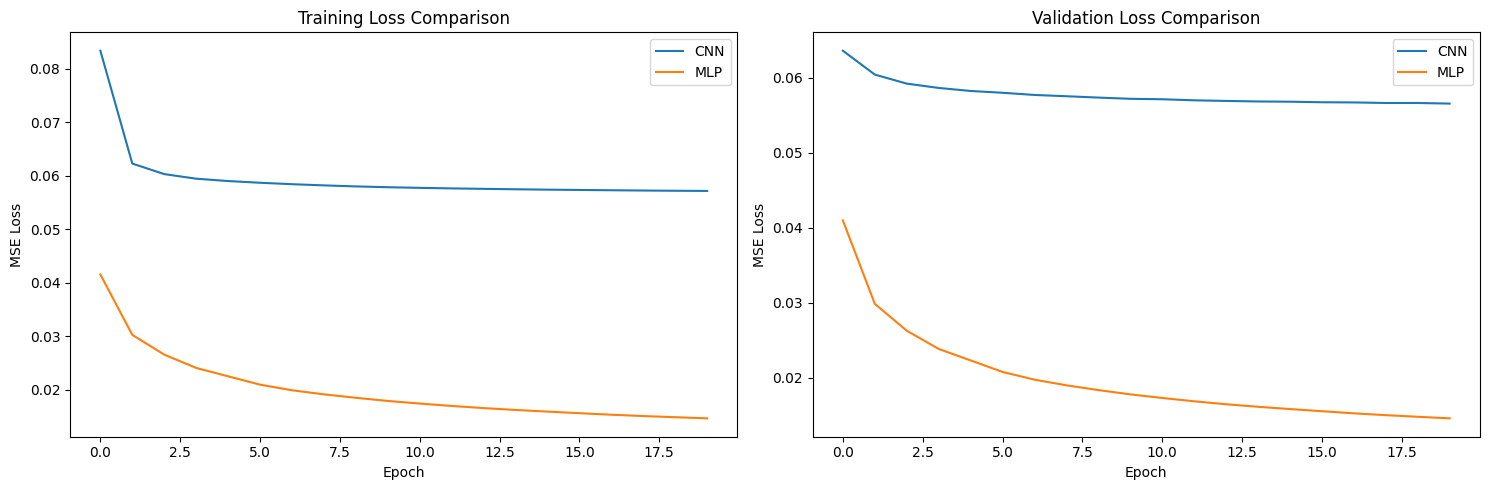

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Prepare data for MLP (flatten images)
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten 28x28 to 784
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Initialize and train MLP Autoencoder
mlp_autoencoder = AutoEncoder(
    input_size=784,  # 28x28 = 784
    hidden_layers=[512, 256],  # Larger layers for complex image data
    latent_dim=128,
    epochs=20,  # Match with CNN epochs
    learning_rate=0.001,
    batch_size=64,
    activation_function='relu',
    loss_function='mse',
    optimizer='mini_batch',
    beta=0.9,
    weight_init='he',
    wandb_vaar=False,
    run_start="mlp_autoencoder_training",
    wandb_finish=False
)

print("Training MLP Autoencoder...")
mlp_autoencoder.fit(X_train_flat, X_val_flat)

# Get training history from MLP
mlp_train_losses = mlp_autoencoder.mlp.train_loss
mlp_val_losses = mlp_autoencoder.mlp.val_loss

# Plot training curves comparison
plt.figure(figsize=(15, 5))

# Training loss comparison
plt.subplot(1, 2, 1)
plt.plot(cnn_train_losses, label='CNN')
plt.plot(mlp_train_losses, label='MLP')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Validation loss comparison
plt.subplot(1, 2, 2)
plt.plot(cnn_val_losses, label='CNN')
plt.plot(mlp_val_losses, label='MLP')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
print(mlp_train_losses)

[0.04153938740399952, 0.03024350058574606, 0.02655565517626317, 0.024067227806517343, 0.02250261435949904, 0.020938966948931104, 0.01989091876522197, 0.019126950737182024, 0.01848033642146004, 0.01789664676269366, 0.01740740040475859, 0.016958265712739475, 0.016557620108508916, 0.016212588583787844, 0.01590063352849643, 0.015608034909168995, 0.015318645067922309, 0.01507057815571535, 0.014851792072430427, 0.01464269000444185]



Comparing reconstructions from both models:


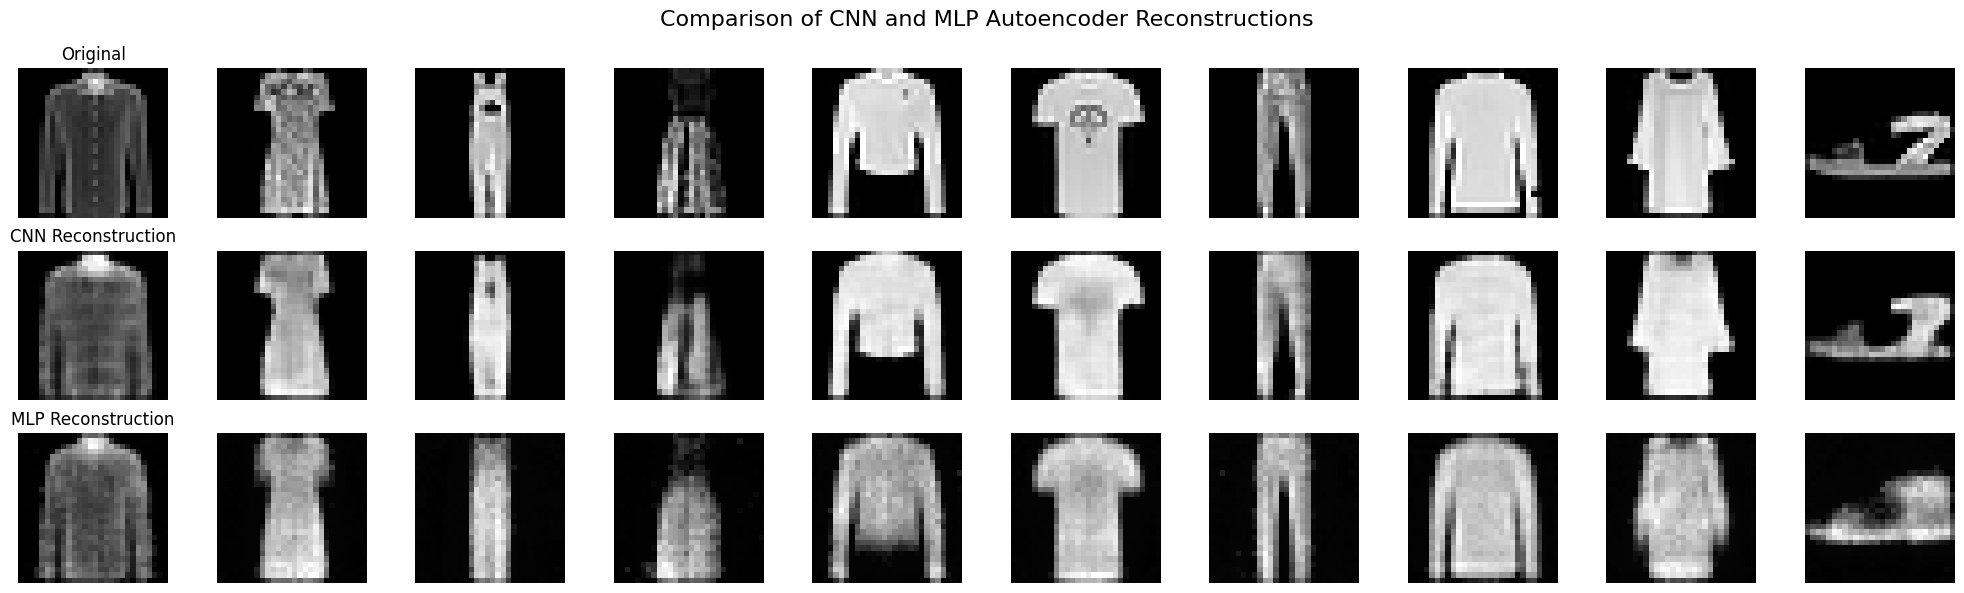


Final Test Losses:
CNN Autoencoder: 0.007095
MLP Autoencoder: 0.014840


In [15]:
# Function to visualize and compare reconstructions
def compare_reconstructions(cnn_model, mlp_autoencoder, test_loader, num_images=10):
    # Get CNN reconstructions
    cnn_model.eval()
    with torch.no_grad():
        images = next(iter(test_loader))[0][:num_images]
        cnn_reconstructed = cnn_model(images.to(device)).cpu().numpy()
        
    # Get MLP reconstructions
    original_flat = images.numpy().reshape(num_images, -1)
    encoded = mlp_autoencoder.encode(original_flat)
    mlp_reconstructed = mlp_autoencoder.reconstruct(encoded)
    
    # Reshape everything to images
    original_images = images.numpy()
    mlp_reconstructed = mlp_reconstructed.reshape(-1, 1, 28, 28)
    
    # Create visualization
    fig, axes = plt.subplots(3, num_images, figsize=(20, 6))
    
    for i in range(num_images):
        # Original
        axes[0, i].imshow(original_images[i][0], cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')
        
        # CNN reconstruction
        axes[1, i].imshow(cnn_reconstructed[i][0], cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('CNN Reconstruction')
        
        # MLP reconstruction
        axes[2, i].imshow(mlp_reconstructed[i][0], cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('MLP Reconstruction')
    
    plt.suptitle('Comparison of CNN and MLP Autoencoder Reconstructions', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Compare reconstructions
print("\nComparing reconstructions from both models:")
compare_reconstructions(cnn_model, mlp_autoencoder, test_loader)

# Calculate and compare final test losses
def calculate_test_loss(model, data, is_cnn=True):
    if is_cnn:
        model.eval()
        with torch.no_grad():
            test_loss = 0
            for batch in test_loader:
                x = batch[0].to(device)
                output = model(x)
                loss = nn.MSELoss()(output, x)
                test_loss += loss.item()
            return test_loss / len(test_loader)
    else:
        encoded = mlp_autoencoder.encode(data)
        reconstructed = model.reconstruct(encoded)
        return np.mean((data - reconstructed) ** 2)

cnn_test_loss = calculate_test_loss(cnn_model, None, is_cnn=True)
mlp_test_loss = calculate_test_loss(mlp_autoencoder, X_test_flat, is_cnn=False)

print("\nFinal Test Losses:")
print(f"CNN Autoencoder: {cnn_test_loss:.6f}")
print(f"MLP Autoencoder: {mlp_test_loss:.6f}")

# Analysis of reconstruction quality
def analyze_reconstruction_quality(original, reconstructed, model_name):
    mse = np.mean((original - reconstructed) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))
    
    print(f"\n{model_name} Reconstruction Quality Metrics:")
    print(f"MSE: {mse:.6f}")
    print(f"PSNR: {psnr:.2f} dB")

# # Get sample reconstructions for analysis
# with torch.no_grad():
#     sample_images = next(iter(test_loader))[0][:100]
#     cnn_reconstructed = cnn_model(sample_images.to(device)).cpu().numpy()
    
# sample_flat = sample_images.numpy().reshape(100, -1)
# encoded = mlp_autoencoder.encode(sample_flat)
# mlp_reconstructed = mlp_autoencoder.reconstruct(encoded).reshape(-1, 1, 28, 28)

# analyze_reconstruction_quality(sample_images.numpy(), cnn_reconstructed, "CNN")
# analyze_reconstruction_quality(sample_images.numpy(), mlp_reconstructed, "MLP")

In [16]:
print(mlp_test_loss)

0.014839785488713115
